Lucy de Haan, Sean Sun, Faye Shipp, Ryan Wang

Title : An Exploration of PLAICRAFT Data
-----------------------------------------

**Introduction**


We have a two datasets: one that tell us about a players Age, Experience, Hours played and a few other factors, and another dataset that records logs of playtime start and stop times.

We aim to use these two datasets to answer a question of our choice through data analysis.

Main Question : Given a player's Age and Experience, how many hours can we predict they will play?

<!-- The dataset that we will use to answer this questions is Players.csv, the dataset that tells us about the player's experience, subscription status, email, hours played, name, gender and age.
 
 - provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
 - clearly state the question you tried to answer with your project
 - identify and fully describe the dataset that was used to answer the question

_____________________________________________________________________________________________

This project aims to answer the question [question here] using data collected by the Pacific Laboratoy of Artificial Intelligence at UBC. The data was collected through PLAICRAFT, a server that tracks the sessions of Mincraft played by participants. Minecraft is a video game set in a universe where everything is cube shaped, wherein players mine for precious stones and gems whilst attemping to build structures and survive the elements.

The data in `players.csv` will be the foundation for answering our exploratory question.
 -->

**Methods and Results**


 
 - describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
 - your report should include code which:
    - loads data 
    - wrangles and cleans the data to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis 
* note: all figures should have a figure number and a legend

_____________________________________________________________________________________________

The first step is loading the tidyverse package which contains all the functions we will use to analyze the data.

In [127]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

The next step is reading the `players.csv` file from the web to this file so that it can be analyzed.

In [128]:

url_players <- "https://raw.githubusercontent.com/lucydehaan/Group-Project/refs/heads/main/players.csv"

players_raw <- read_csv(url_players)

head(players_raw)

# Hopefully we won't need sessions.csv but I'll leave the code here and we can delete later

# url_sessions <- "https://raw.githubusercontent.com/lucydehaan/Group-Project/refs/heads/main/sessions.csv"

# sessions_raw <- read_csv(url_sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Next, we want to tidy this data so that it is easier wrangle. We will:


1. Convert all column names to lowercase using `tolower`and separate each word with an underscore
2. Convert data types. ex. from `< chr >` to `< fct >`

In [129]:
players_tidy <- players_raw |>
    rename_with(tolower)|>
    # mutate(experience = factor(experience)) |>
    # please don't uncomment the above line -- it makes the following code break
    mutate(gender = factor(gender)) |>
    mutate(age = as.integer(age)) |>
    rename(hashed_email = hashedemail) |>
    drop_na()

head(players_tidy)

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


The next step is preparing out data for the KNN regression model we want to apply. First we convert the experience column to factors. Then we order the factors from least to most experience which establishes a relationship between the classes and allows the model to apply regression based on the scalar values assigned to these variables (1,2,3,4,5).

In [130]:
# we want to wrangle the data a bit further.
# in order to make a KNN model, we'll have to convert "experience" into numeric values. 

# don't worry about the "merged3" name, it's a temporary placeholder.

merged3 <- players_tidy |> mutate(experience = as.integer(factor(experience, 
                          levels = c("Beginner", "Amateur", "Regular", "Veteran", 
                                     "Pro"), ordered = TRUE)))


#from here, we'll select just the columns we want to use.

data <- merged3 |> select(experience, played_hours, age)
head(data)



experience,played_hours,age
<int>,<dbl>,<int>
5,30.3,9
4,3.8,17
4,0.0,17
2,0.7,21
3,0.1,21
2,0.0,17


First, let's visualize plot each predictor against the variable of interest : `played_hours`. And both plots will be set on a scale of log 10 because most of the data is centered around less than 10 hours played.

Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”


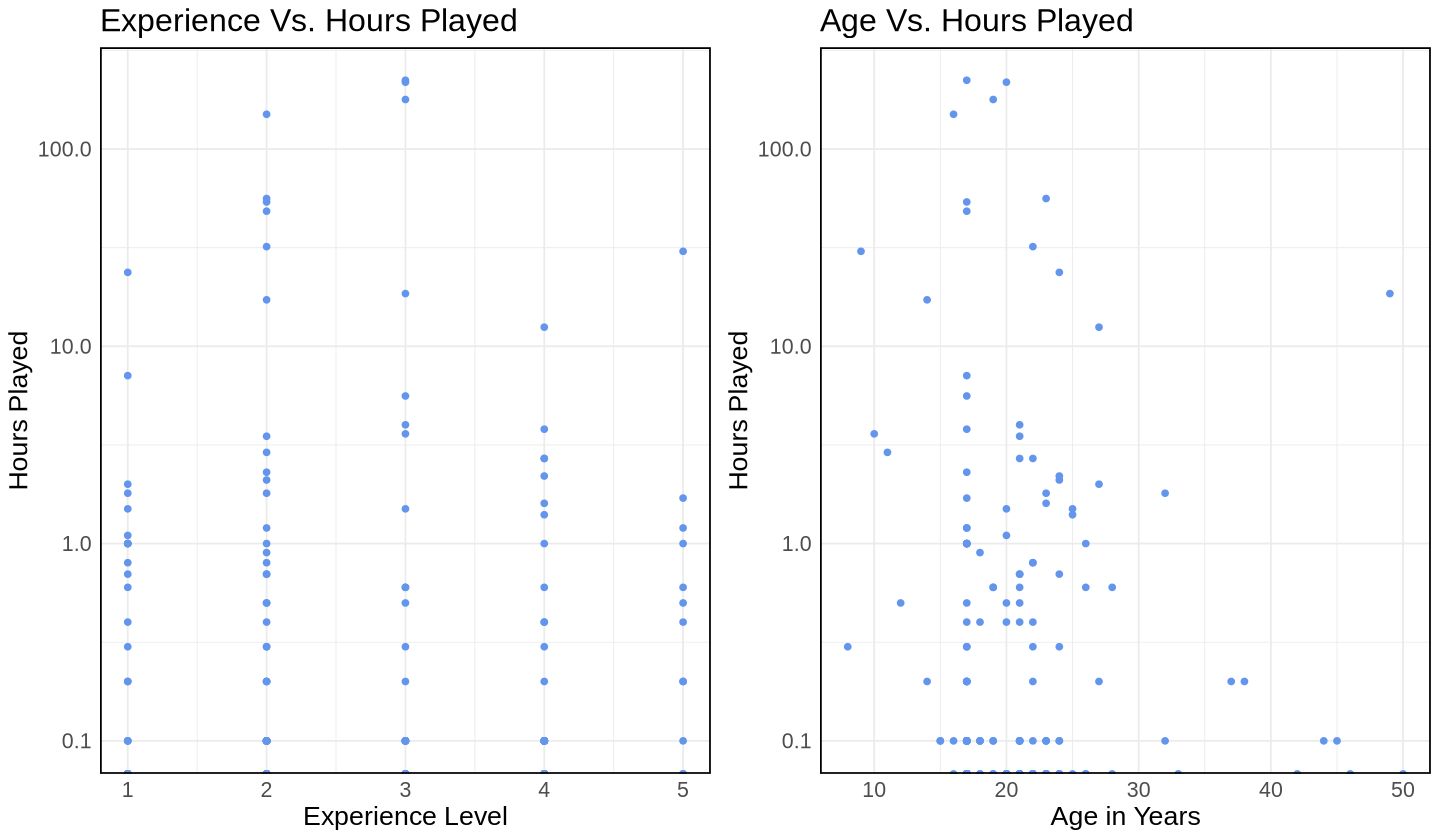

In [131]:
# this is similar to what was done in the invividual portion, but I think it's good to have a starting plot
# so that the reader can follow the process from start to end

options(repr.plot.width = 12, repr.plot.height = 7)

experience_plot <- ggplot(data,aes(x = experience, y = played_hours)) +
    geom_point(color = "cornflowerblue") +
    theme_minimal() +
    scale_y_continuous(trans = 'log10') +
    labs(title = "Experience Vs. Hours Played", x = "Experience Level", y = "Hours Played") +
    theme(panel.border = element_rect(color = "black", fill = NA, size = 1),
          text = element_text(size = 16))

age_plot <- ggplot(data,aes(x = age, y = played_hours)) +
    geom_point(color = "cornflowerblue") +
    theme_minimal() +
    scale_y_continuous(trans = 'log10') +
    labs(title = "Age Vs. Hours Played", x = "Age in Years", y = "Hours Played") +
    theme(panel.border = element_rect(color = "black", fill = NA, size = 1),
          text = element_text(size = 16))

plot_grid(experience_plot, age_plot, ncol = 2)

Since there does not appear to be a strong linear relationship in either of the predictors, we will opt for KNN regression as opposed to linear regression. Here we split the tidy data and apply a KNN regression model to the training set. We chose to split it into 25% testing and 75% training because we have a relatively small data set with under 200 observations. We wanted to ensure we could maintain a sizeable testing set to adequately analyze the efficacy of our model at the end. It is also because of this small data set that we chose to use a 5-fold cross validation instead of 10-fold.

In [156]:
 set.seed(69420)
# predict played_hours from experience, Age
# multivariable knn regression gives 3D plots which we were told to avoid :( 
# i think we could evaluate each predictor separately then we can try a multivariable prediction and
# see if combining the variables gives a more accurate model or not.
# otherwise we have nothing to visualize


#split the data into training and testing
data_split <- initial_split(data, prop = 0.75, strata = played_hours)  
data_train <- training(data_split)
data_test <- testing(data_split)

age_recipe <- data_train_recipe <- recipe(played_hours ~ age, data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

age_vfold <- vfold_cv(data_train, v = 5, strata = played_hours)

age_workflow <- workflow() |>
    add_recipe(age_recipe) |>
    add_model(age_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 5))

age_results <- age_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>  
    collect_metrics()

age_k_min <- age_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)

age_k_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,26.44303,5,7.247682,Preprocessor1_Model07


In [157]:
age_min <- age_k_min |>
         pull(neighbors)

age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = age_min) |>
         set_engine("kknn") |>
         set_mode("regression")

age_best_fit <- workflow() |>
         add_recipe(age_recipe) |>
         add_model(age_best_spec) |>
         fit(data = data_train)
#evaluate the model
data_summary <- age_best_fit |>
          predict(data_test) |>
          bind_cols(data_test) |>
          metrics(truth = played_hours, estimate = .pred)
data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.89866585
rsq,standard,0.02479718
mae,standard,8.33238973


Now that we have collected summary statistics for our model before and after testing it on `data_test`, we can visualize the model.

Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”


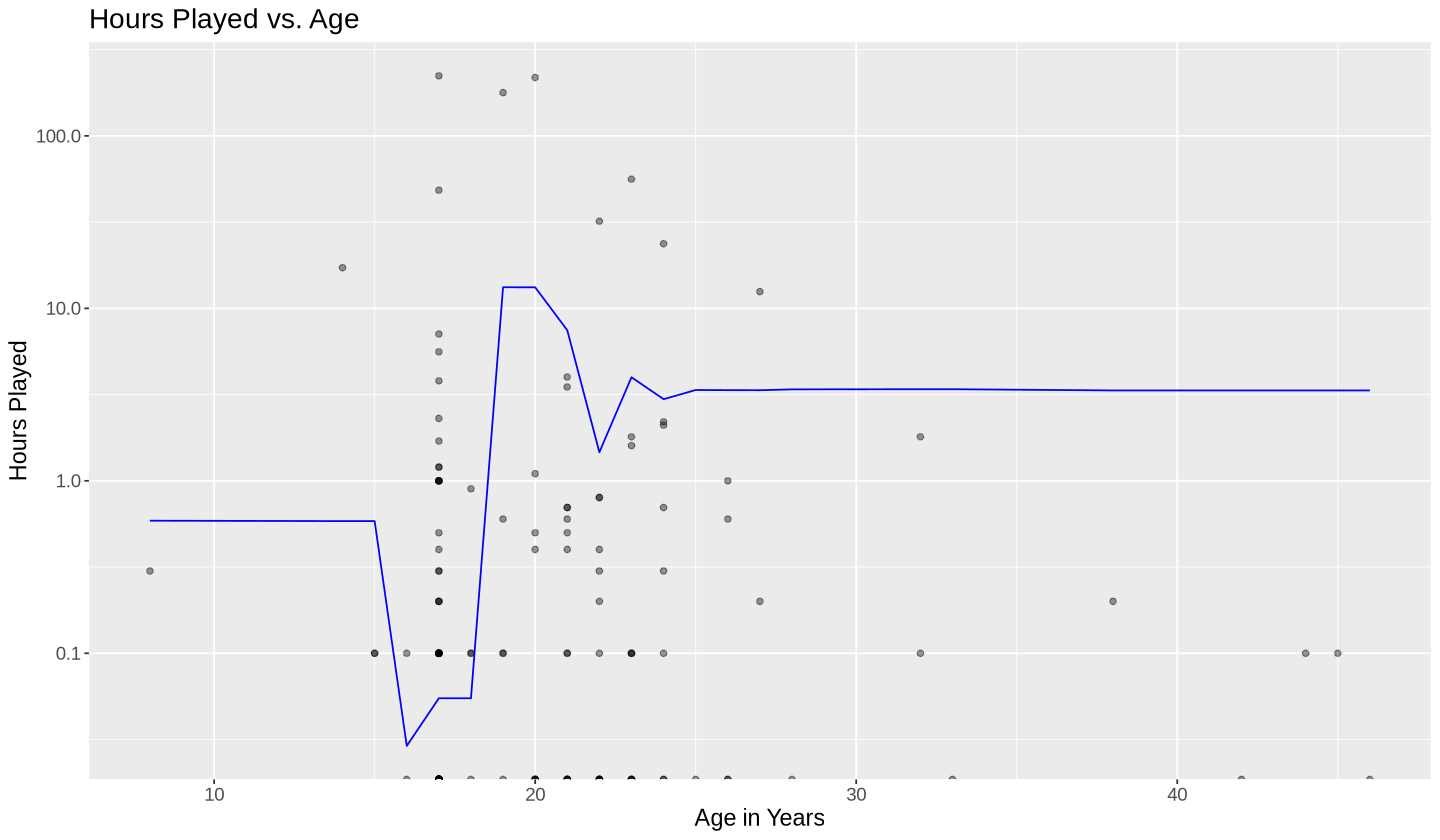

In [159]:
age_preds <- age_best_fit |>
    predict(data_train)|>
    bind_cols(data_train)

marathon_plot <- age_preds |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    scale_y_continuous(trans = 'log10') +
    geom_line(data = arrange(age_preds, age),
            mapping = aes(x = age, y = .pred),
            color = "blue") +
            labs(x = "Age in Years", y= "Hours Played", title = "Hours Played vs. Age") +
            theme(text = element_text(size = 14))
marathon_plot

In [149]:
set.seed(69420)

data_train_recipe <- recipe(played_hours ~ experience + age , data = data_train) |>
# step_normalize(all_predictors())
                        # normalizing gives a lower standard error than scale+center,
                        # but either way all the metrics say our model is trash *crying emoji*
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# data_train_recipe


#find optimal k
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

data_vfold <- vfold_cv(data_train, v = 5, strata = played_hours)

data_workflow <- workflow() |>
    add_recipe(data_train_recipe) |>
    add_model(data_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 5))

k_data_results <- data_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>  
    collect_metrics()

k_data_min <- k_data_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)

k_data_min

#for some reason it doesn't like the vfold? or the gridvals...? plz debug

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,26.34792,5,6.547614,Preprocessor1_Model07


In [160]:
set.seed(69420)

#do the model

k_min <- k_data_min |>
         pull(neighbors)

data_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

data_best_fit <- workflow() |>
         add_recipe(data_train_recipe) |>
         add_model(data_best_spec) |>
         fit(data = data_train)
#evaluate the model
data_summary <- data_best_fit |>
          predict(data_test) |>
          bind_cols(data_test) |>
          metrics(truth = played_hours, estimate = .pred)
data_summary

#yeah the data really doesn't like the bind_cols. Similar issue to the code above. 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.89866585
rsq,standard,0.02479718
mae,standard,8.33238973


**Discussion**

 - summarize what you found
 - discuss whether this is what you expected to find?
 - discuss what impact could such findings have?
 - discuss what future questions could this lead to?

**References**

 - You may include references if necessary, as long as they all have a consistent citation style.

(I don't think we need this but I'll leave it here in case)